In [146]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn import datasets
from sklearn.metrics import normalized_mutual_info_score as nmi
from sklearn.neighbors import kneighbors_graph
from robust_spectral_clustering_rbf import RSC

import matplotlib.pyplot as plt
%matplotlib inline

In [147]:
X, y = datasets.make_moons(200, shuffle=False, random_state=1, noise=0.05) 
# X, y = datasets.make_blobs(200, centers=[[1, 0], [0, 7]],shuffle=False, random_state=4) 
# X, y = datasets.make_circles(200, shuffle=False, random_state=4, noise=0.075,  factor=0.4) 
# n_normal = X.shape[0]
# X = np.concatenate([X, np.random.rand(10, 2)*1.0], axis=0) # outliers 
# y = np.concatenate([y, np.ones((10, ), dtype=int)*2] )
n_outliers = 10 
k = 2
nn = 15
print(y)
print(k)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
2


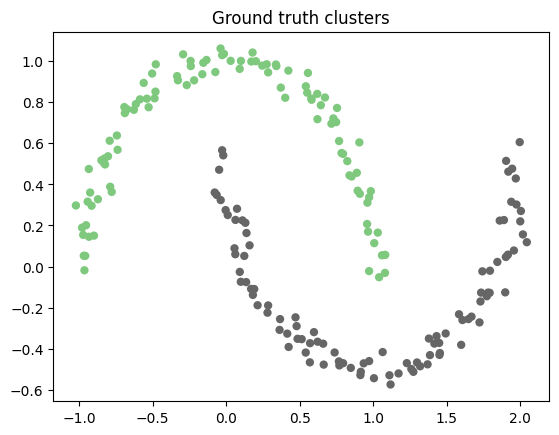

In [148]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Accent', linewidths=0)
plt.title('Ground truth clusters');

In [149]:
from scipy.stats import stats
from sklearn.metrics import pairwise_distances


def compute_bandwidth(X, q = 0.3):
    pd = pairwise_distances(X, Y=None, metric='euclidean')
    qs = np.quantile(pd, q=q, axis=1)
    alpha = 0.01
    n, d = X.shape
    df = d  # degrees of freedom
    denominator = np.sqrt(stats.chi2.ppf((1 - alpha), df))
    bandwidth = np.quantile(qs, (1 - alpha)) / denominator

    return bandwidth

# @timer
def sc_embedding(points, k, n_neighbors=10, affinity='knn', q=1, normalize=False, random_state=42):
    from sklearn.metrics import pairwise_kernels
    params = {}  # default value in slkearn
    # https://github.com/scikit-learn/scikit-learn/blob/872124551/sklearn/cluster/_spectral.py#L667
    # Number of eigenvectors to use for the spectral embedding, default=n_clusters
    n_components = k
    eigen_tol = 0.0
    eigen_solver = None
    # affinity = 'rbf'  # affinity str or callable, default =’rbf’
    if affinity == 'rbf':
        # params["gamma"] = 1.0  # ?
        # sigma = compute_bandwidth(points)
        # params["gamma"] = 1 / (2 * sigma ** 2)

        # pd = pairwise_distances(points, Y=None, metric='euclidean')
        # # v = np.quantile(pd, q=q)
        # # params["gamma"] = 1/(2*v**2)
        # # Step 2: Calculate the standard deviation of pairwise distances
        # sigma = np.std(pd)
        # params["gamma"] = 1 / (2 * sigma ** 2) * q

        # pd = pairwise_distances(points, Y=None, metric='euclidean')
        # beta = q
        # qs = np.quantile(pd, q=beta, axis=1)
        # alpha = 0.01
        # n, d = points.shape
        # df = d  # degrees of freedom
        # denominator = np.sqrt(stats.chi2.ppf((1 - alpha), df))
        # bandwidth = np.quantile(qs, (1 - alpha)) / denominator
        # params["gamma"] = 1 / (2 * bandwidth ** 2)

        # params["degree"] = 3
        # params["coef0"] = 1
        # # eigen_solver{‘arpack’, ‘lobpcg’, ‘amg’}, default=None
        # The eigenvalue decomposition strategy to use. AMG requires pyamg to be installed.
        # It can be faster on very large, sparse problems, but may also lead to instabilities.
        # If None, then 'arpack' is used. See [4] for more details regarding 'lobpcg'.

        sigma = compute_bandwidth(points, q=q)
        gamma = 1 / (2 * sigma ** 2)
        affinity_matrix_ = pairwise_kernels(
            points, metric=affinity, filter_params=True, gamma=gamma,
        )
        np.fill_diagonal(affinity_matrix_, 0)
    else:  # if affinity == "nearest_neighbors":
        mode = "connectivity"
        connectivity = kneighbors_graph(
            points, n_neighbors=n_neighbors, metric='euclidean', include_self=False, mode=mode)
        # affinity_matrix_ = 0.5 * (connectivity + connectivity.T).toarray()
        affinity_matrix_ = connectivity.maximum(connectivity.T).toarray()  # make the graph undirected
        if mode == 'distance':
            # affinity_matrix_ = 1/affinity_matrix_
            # the bigger the distance, the smaller the similarity
            affinity_matrix_ = np.where(affinity_matrix_ != 0, 1 / affinity_matrix_, 0)
    # print(affinity_matrix_)
    # We now obtain the real valued solution matrix to the
    # relaxed Ncut problem, solving the eigenvalue problem
    # L_sym x = lambda x  and recovering u = D^-1/2 x.
    # The first eigenvector is constant only for fully connected graphs
    # and should be kept for spectral clustering (drop_first = False)
    # See spectral_embedding documentation.
    from sklearn.manifold import spectral_embedding
    H = spectral_embedding(
        affinity_matrix_,  # n xn
        n_components=n_components,
        eigen_solver=eigen_solver,
        random_state=random_state,
        eigen_tol=eigen_tol,
        norm_laplacian=True,
        drop_first=False,
    )
    # print(np.min(points), np.max(points), np.min(affinity_matrix_), np.max(affinity_matrix_), np.min(maps), np.max(maps), flush=True)
    # MAX=1e+5
    # maps[maps > MAX] = MAX  # avoid overflow in np.square()
    # maps[maps < -MAX] = -MAX
    # print(np.min(points), np.max(points), np.min(affinity_matrix_), np.max(affinity_matrix_), np.min(maps),
    #       np.max(maps), flush=True)
    if normalize:
        projected_points = H / np.linalg.norm(H, axis=1)[:, None]
    else:
        projected_points = H
    return projected_points



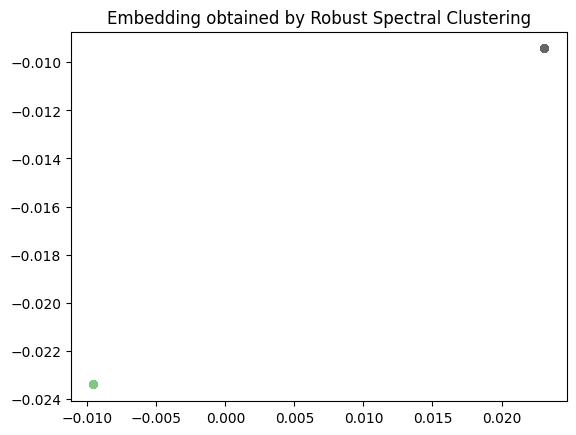

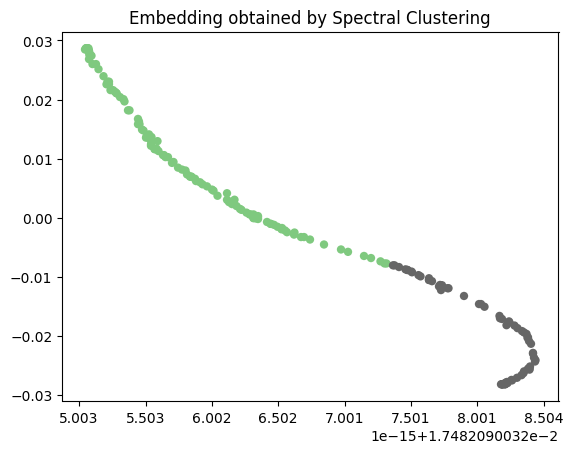

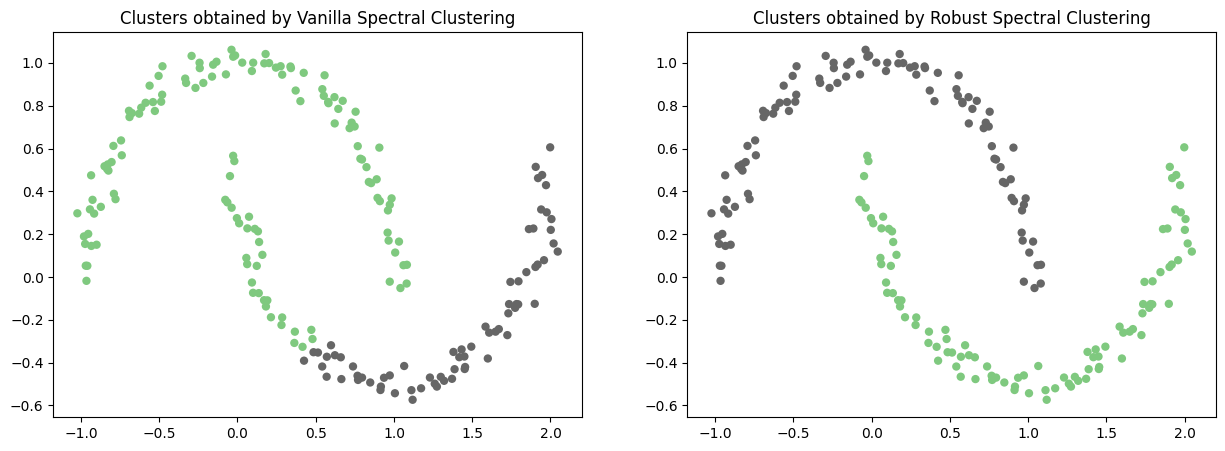

[1.0, 0.5005759562253224, 15, 50, 0.5, array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int32), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [150]:
best = [0, 0]
# for theta in [1, 10, 20, 50, 100, 200]:
#     for m in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
from itertools import product 
nns = [15] # [5, 10, 15, 20, 100] # number of neighbours to consider for constructing the KNN graph (excluding the node itself)
thetas = [50]     # number of corrupted edges to remove/2 = theta
ms= [0.5] # [0.1, 0.2, 0.3, 0.4, 0.5]  # minimum  percentage of neighbours will be removed for each node (omega_i constraints)
for nn, theta, m in product(nns, thetas, ms): 
    try:
        #   print(f"*** theta: {theta}, m={m}")
        rsc = RSC(k=k, nn=nn, theta=theta, m=m, affinity='knn', verbose=False)
        y_rsc = rsc.fit_predict(X)
        # print(rsc.h)
        plt.scatter(rsc.H[:, 0], rsc.H[:, 1], c=y_rsc,  cmap='Accent', linewidths=0)
        plt.title('Embedding obtained by Robust Spectral Clustering')
        plt.show()

        # print(y_rsc)
        nmi_rsc = nmi(y, y_rsc)

        # sc = SpectralClustering(n_clusters=k, n_neighbors=nn+1, affinity='nearest_neighbors')  # nn+1 since they include self
        # y_sc = sc.fit_predict(X)
        X_sc = sc_embedding(X, k, affinity='knn', q=0.3, n_neighbors=nn, normalize=False, random_state=42)
        from _kmeans import k_means as sklearn_k_means
        centroids_, labels_, inertia_, *_ = sklearn_k_means(X=X_sc, n_clusters=k,
                                                                                   init='k-means++',
                                                                                   n_init=1,
                                                                                   random_state=42)
        y_sc = labels_
        plt.scatter(X_sc[:, 0], X_sc[:, 1], c=y_sc,  cmap='Accent', linewidths=0)
        plt.title('Embedding obtained by Spectral Clustering')
        plt.show()
        # print(y_sc)
        nmi_sc = nmi(y, y_sc)
    #         print('Vanilla Spectral Clustering NMI: {:.4f}\n Robust Spectral Clustering NMI: {:.4f}'.format(nmi(y, y_sc), nmi(y, y_rsc)))

        if nmi_rsc > best[0]:
            best = [nmi_rsc, nmi_sc, nn, theta, m, y_rsc, y_sc]
            
        y_sc, y_rsc = best[-1], best[-2]
        fig, ax = plt.subplots(1, 2, figsize=[15, 5])
        ax[0].scatter(X[:, 0], X[:, 1], c=y_sc, cmap='Accent', linewidths=0)
        ax[0].set_title('Clusters obtained by Vanilla Spectral Clustering')
        
        ax[1].scatter(X[:, 0], X[:, 1], c=y_rsc, cmap='Accent', linewidths=0)
        ax[1].set_title('Clusters obtained by Robust Spectral Clustering');
        plt.show()
    except Exception as e:
        print(e, nn, theta)
print(best)

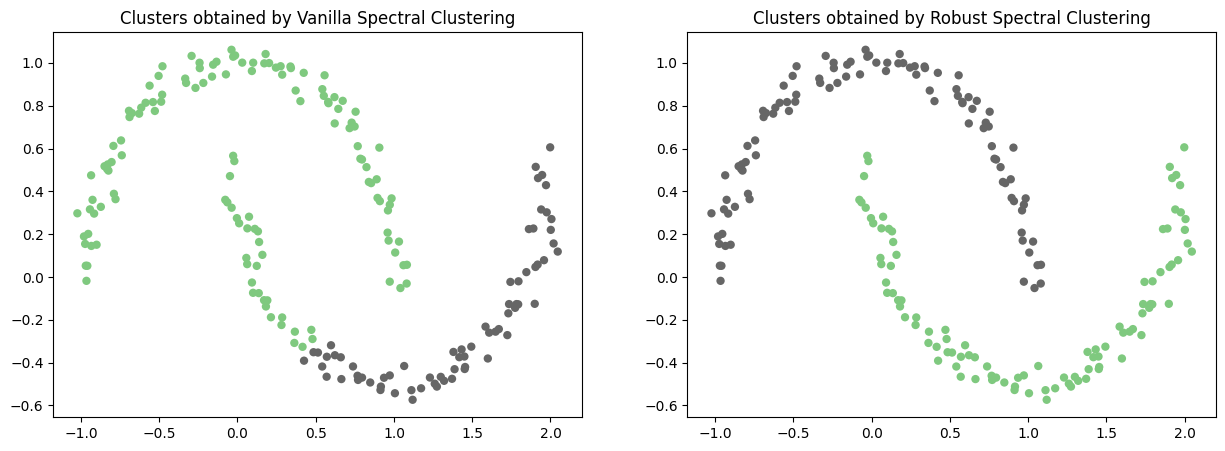

In [151]:
y_sc, y_rsc = best[-1], best[-2]
fig, ax = plt.subplots(1, 2, figsize=[15, 5])
ax[0].scatter(X[:, 0], X[:, 1], c=y_sc, cmap='Accent', linewidths=0)
ax[0].set_title('Clusters obtained by Vanilla Spectral Clustering')

ax[1].scatter(X[:, 0], X[:, 1], c=y_rsc, cmap='Accent', linewidths=0)
ax[1].set_title('Clusters obtained by Robust Spectral Clustering');

[-4.56828207e-17 -1.68927132e-17]


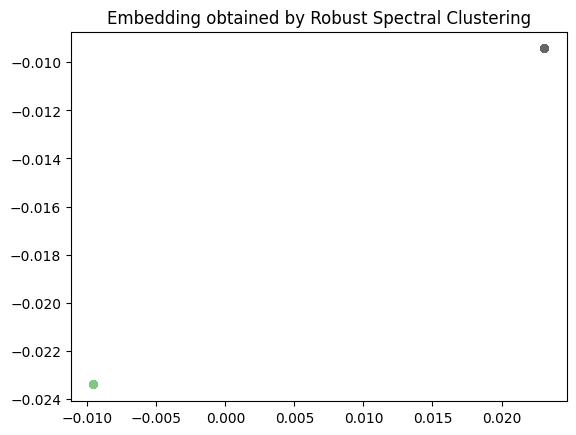

In [152]:
print(rsc.h)
plt.scatter(rsc.H[:, 0], rsc.H[:, 1], c=y_rsc,  cmap='Accent', linewidths=0)
plt.title('Embedding obtained by Robust Spectral Clustering');

In [153]:
rsc.H[:, 0]

array([ 0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02310455,
        0.02310455,  0.02310455,  0.02310455,  0.02310455,  0.02

In [154]:
rsc.H[:, 1]

array([-0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00942575,
       -0.00942575, -0.00942575, -0.00942575, -0.00942575, -0.00

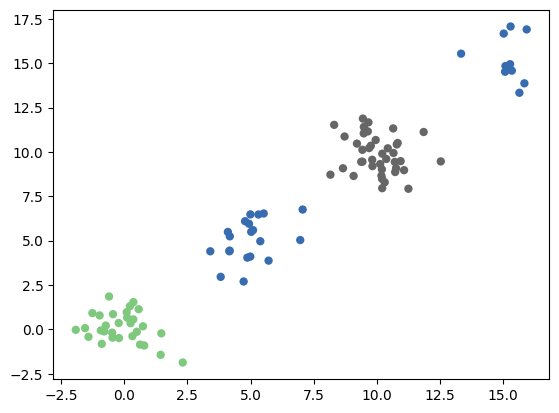

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[-1.5793577476324663e-16, 6.799034311174347e-17, 1.3917894817866948e-16, 0.29607865429626856] [6.799034311174347e-17, 1.3917894817866948e-16, -1.5793577476324663e-16, 0.29607865429626856]
h[i] - h[i-1] diff：  [2.2592611787499007e-16, 7.118860506692601e-17, 0.2960786542962684]
Iter: 1, prev_trace - trace: -1.538087333910704e-16, Trace: -0.0000 h: [-1.57935775e-16  6.79903431e-17]
[-1.57935775e-16  6.79903431e-17] 2


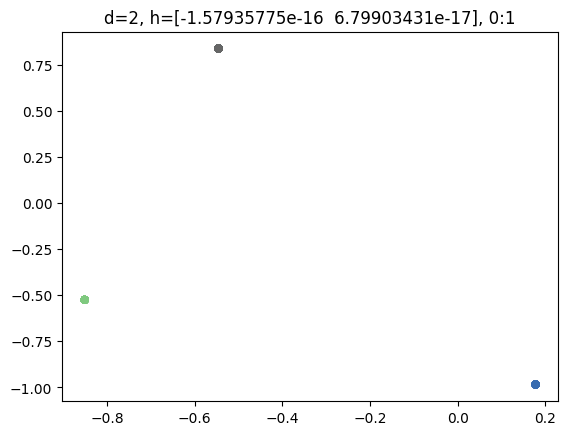

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[-2.3467310451118023e-16, -6.95101948546396e-17, 9.429118089239772e-17, 0.28731718758639707] [-6.95101948546396e-17, 9.429118089239772e-17, -2.3467310451118023e-16, 0.28731718758639707]
h[i] - h[i-1] diff：  [1.6516290965654064e-16, 1.6380137574703734e-16, 0.28731718758639696]
Iter: 1, prev_trace - trace: 6.042913432324627e-17, Trace: -0.0000 h: [-2.34673105e-16 -6.95101949e-17]
[-2.34673105e-16 -6.95101949e-17] 2


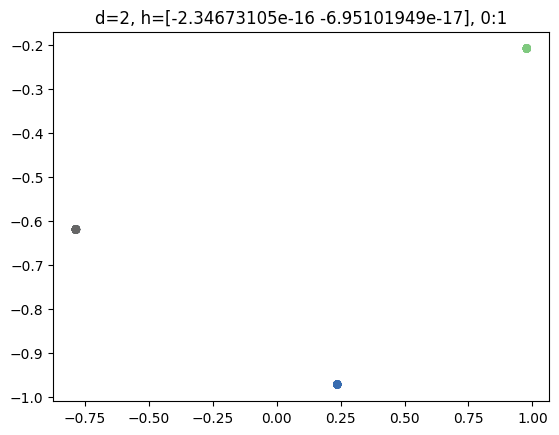

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668] [6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668]
h[i] - h[i-1] diff：  [5.567940626291341e-17, 3.515386099002407e-18, 0.29043342924126675]
Iter: 1, prev_trace - trace: -3.1323194977449633e-16, Trace: 0.0000 h: [6.89918923e-18 6.25785955e-17]
[6.89918923e-18 6.25785955e-17] 2


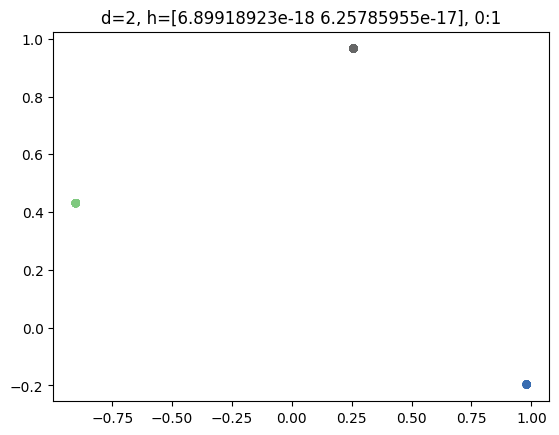

Using random walk based normalized Laplacian L_rw
[-1.9692668970744843e-16, -4.6827475335125147e-17, 1.4260209158910981e-16, 0.29688381167203576] [-4.6827475335125147e-17, 1.4260209158910981e-16, -1.9692668970744843e-16, 0.29688381167203576]
h[i] - h[i-1] diff：  [1.5009921437232328e-16, 1.8942956692423496e-16, 0.2968838116720356]
Iter: 0, prev_trace - trace: inf, Trace: -0.0000 h: [-1.96926690e-16 -4.68274753e-17]
[6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668] [6.899189234504683e-18, 6.25785954974181e-17, 6.60939815964205e-17, 0.2904334292412668]
h[i] - h[i-1] diff：  [5.567940626291341e-17, 3.515386099002407e-18, 0.29043342924126675]
Iter: 1, prev_trace - trace: -3.1323194977449633e-16, Trace: 0.0000 h: [6.89918923e-18 6.25785955e-17]
[6.89918923e-18 6.25785955e-17] 2


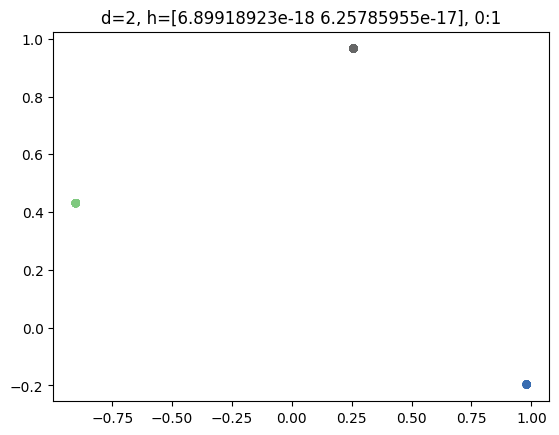

In [155]:
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from sklearn.metrics import silhouette_score
# Generate synthetic data with 3 clusters
np.random.seed(42)
data = np.random.randn(100, 10)
data[30:60] += 5
data[50:] += 10

y = [0]* 30 + [1]*30 + [2]*40
X = data
plt.scatter(X[:, 0], X[:, 1],c = y, cmap='Accent', linewidths=0)
plt.show() 

# Evaluate silhouette score for different embedding dimensions
# embedding_dimensions = range(2, 6)
silhouette_scores = []
ms = [0.1, 0.2, 0.4, 0.5]
for d in ms:
    # spectral = SpectralClustering(n_clusters=3, eigen_solver='arpack', affinity='nearest_neighbors', n_neighbors=10, n_components=d)
    # labels = spectral.fit_predict(data)
    # silhouette_scores.append(silhouette_score(data, labels))
    
    # connectivity = kneighbors_graph(
    #             X, n_neighbors=10, include_self=True, n_jobs=None
    #         )
    # affinity_matrix_ = 0.5 * (connectivity + connectivity.T)
    # 
    # maps = spectral_embedding(
    #     affinity_matrix_,
    #     n_components=d,
    #     eigen_solver=None,
    #     random_state=None,
    #     eigen_tol=0.0,
    #     norm_laplacian=True,
    #     drop_first=True,
    # )
    
    rsc = RSC(k=2, nn=15, theta=20, m=d,laplacian=1,  normalize=True, verbose=True, random_state=42)
    # y_rsc = rsc.fit_predict(X)
    Ag, Ac, H = rsc._RSC__latent_decomposition(data)
    # # Ag: similarity matrix of good points
    # # Ac: similarity matrix of corruption points
    # # A = Ag + Ac
    # rsc.Ag = Ag
    # rsc.Ac = Ac

    if rsc.normalize:
        rsc.H = H / np.linalg.norm(H, axis=1)[:, None]
    else:
        rsc.H = H

    projected_points = rsc.H
    print(rsc.h, rsc.k, flush=True)
    if len(rsc.h) >=2:
        
        for i in range(len(rsc.h)-1):
            plt.scatter(projected_points[:, i], projected_points[:, i+1], c=y, cmap='Accent', linewidths=0)
            plt.title(f'd=2, h={rsc.h}, {i}:{i+1}')
        plt.show() 

# # Plot silhouette scores
# plt.plot(embedding_dimensions, silhouette_scores, marker='o')
# plt.xlabel('Embedding Dimension')
# plt.ylabel('Silhouette Score')
# plt.title('Silhouette Score vs. Embedding Dimension')
# plt.show()
